In [1]:
import json

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pydicom

from keras import layers
from keras.applications import DenseNet121, ResNet50V2, InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import Constant
from keras.utils import Sequence
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.layers import GlobalAveragePooling2D, Dense, Activation, concatenate, Dropout
from keras.initializers import glorot_normal, he_normal
from keras.regularizers import l2

import keras.metrics as M
import tensorflow_addons as tfa
import pickle

from keras import backend as K

import tensorflow as tf
from tensorflow.python.ops import array_ops

from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold

import warnings
warnings.filterwarnings(action='once')

KeyboardInterrupt: 

In [12]:
import os
import pydicom

base_path = '/D:\sem5\8 - EN2550 - Fundamentals of Image Processing & Machine Vision\project'
dicom_data = {}  # Dictionary to store metadata

# Walk through the directory and its subdirectories
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith(".dcm"):
            dicom_path = os.path.join(root, file)
            try:
                ds = pydicom.dcmread(dicom_path)
                sop_instance_uid = ds.SOPInstanceUID
                series_instance_uid = ds.SeriesInstanceUID
                study_instance_uid = ds.StudyInstanceUID
                metadata = {
                    "SOPInstanceUID": sop_instance_uid,
                    "SeriesInstanceUID": series_instance_uid,
                    "StudyInstanceUID": study_instance_uid
                }
                dicom_data[dicom_path] = metadata
            except Exception as e:
                print(f"Error processing {dicom_path}: {str(e)}")

# Print the dictionary with metadata
for path, metadata in dicom_data.items():
    print("Image Path:", path)
    print("Metadata:", metadata)
    print()


In [11]:
BASE_PATH = '../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/'
TRAIN_DIR = 'stage_2_train/'
TEST_DIR = 'stage_2_test/'

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
train_df = pd.read_csv(BASE_PATH + 'stage_2_train.csv')
#sub_df = pd.read_csv(BASE_PATH + 'stage_1_sample_submission.csv')

train_df['id'] = train_df['ID'].apply(lambda st: "ID_" + st.split('_')[1])
train_df['subtype'] = train_df['ID'].apply(lambda st: st.split('_')[2])
#sub_df['filename'] = sub_df['ID'].apply(lambda st: "ID_" + st.split('_')[1] + ".png")
#sub_df['type'] = sub_df['ID'].apply(lambda st: st.split('_')[2])

print(train_df.shape)
train_df.head()

(4516842, 4)


,ID,Label,id,subtype
0,ID_12cadc6af_epidural,0,ID_12cadc6af,epidural
1,ID_12cadc6af_intraparenchymal,0,ID_12cadc6af,intraparenchymal
2,ID_12cadc6af_intraventricular,0,ID_12cadc6af,intraventricular
3,ID_12cadc6af_subarachnoid,0,ID_12cadc6af,subarachnoid
4,ID_12cadc6af_subdural,0,ID_12cadc6af,subdural


In [13]:
train_df = train_df[["id","subtype","Label"]]
train_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,subtype,Label
0,ID_12cadc6af,epidural,0
1,ID_12cadc6af,intraparenchymal,0
2,ID_12cadc6af,intraventricular,0
3,ID_12cadc6af,subarachnoid,0
4,ID_12cadc6af,subdural,0


In [14]:
train_df = pd.pivot_table(train_df,index="id",columns="subtype",values="Label")
train_df.head()



/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
id,,,,,,
ID_000012eaf,0,0,0,0,0,0
ID_000039fa0,0,0,0,0,0,0
ID_00005679d,0,0,0,0,0,0
ID_00008ce3c,0,0,0,0,0,0
ID_0000950d7,0,0,0,0,0,0


In [15]:
pivot_df = train_df.copy()
#bad = []
#for index,row in tqdm(pivot_df.iterrows()):
#    f = BASE_PATH+TRAIN_DIR+index+".dcm"
#    dcm = pydicom.dcmread(f)
#    try:
#        d = dcm.pixel_array
#    except:
#        bad.append(index)
pivot_df.drop("ID_6431af929",inplace=True)
#print(bad)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
def map_to_gradient(grey_img):
    rainbow_img = np.zeros((grey_img.shape[0], grey_img.shape[1], 3))
    rainbow_img[:, :, 0] = np.clip(4 * grey_img - 2, 0, 1.0) * (grey_img > 0) * (grey_img <= 1.0)
    rainbow_img[:, :, 1] =  np.clip(4 * grey_img * (grey_img <=0.75), 0,1) + np.clip((-4*grey_img + 4) * (grey_img > 0.75), 0, 1)
    rainbow_img[:, :, 2] = np.clip(-4 * grey_img + 2, 0, 1.0) * (grey_img > 0) * (grey_img <= 1.0)
    return rainbow_img

def rainbow_window(dcm):
    grey_img = window_image(dcm, 40, 80)
    return map_to_gradient(grey_img)


def sigmoid_window(dcm, window_center, window_width, U=1.0, eps=(1.0 / 255.0)):
    img = dcm.pixel_array
    img = cp.array(np.array(img))
    _, _, intercept, slope = get_windowing(dcm)
    img = img * slope + intercept
    ue = cp.log((U / eps) - 1.0)
    W = (2 / window_width) * ue
    b = ((-2 * window_center) / window_width) * ue
    z = W * img + b
    img = U / (1 + cp.power(np.e, -1.0 * z))
    img = (img - cp.min(img)) / (cp.max(img) - cp.min(img))
    return cp.asnumpy(img)

def sigmoid_bsb_window(dcm):
    brain_img = sigmoid_window(dcm, 40, 80)
    subdural_img = sigmoid_window(dcm, 80, 200)
    bone_img = sigmoid_window(dcm, 600, 2000)
    
    bsb_img = np.zeros((brain_img.shape[0], brain_img.shape[1], 3))
    bsb_img[:, :, 0] = brain_img
    bsb_img[:, :, 1] = subdural_img
    bsb_img[:, :, 2] = bone_img
    return bsb_img

def window_image(dcm, window_center, window_width):
    _, _, intercept, slope = get_windowing(dcm)
    img = dcm.pixel_array * slope + intercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img[img < img_min] = img_min
    img[img > img_max] = img_max
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    bone_img = window_image(dcm, 600, 2000)
    
    bsb_img = np.zeros((brain_img.shape[0], brain_img.shape[1], 3))
    bsb_img[:, :, 0] = brain_img
    bsb_img[:, :, 1] = subdural_img
    bsb_img[:, :, 2] = bone_img
    return bsb_img
    
def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

In [22]:
def preprocess(file,type="WINDOW"):
    dcm = pydicom.dcmread(file)
    if type == "WINDOW":
        window_center , window_width, intercept, slope = get_windowing(dcm)
        w = window_image(dcm, window_center, window_width)
        win_img = np.repeat(w[:, :, np.newaxis], 3, axis=2)
        #return win_img
    elif type == "SIGMOID":
        window_center , window_width, intercept, slope = get_windowing(dcm)
        test_img = dcm.pixel_array
        w = sigmoid_window(dcm, window_center, window_width)
        win_img = np.repeat(w[:, :, np.newaxis], 3, axis=2)
        #return win_img
    elif type == "BSB":
        win_img = bsb_window(dcm)
        #return win_img
    elif type == "SIGMOID_BSB":
        win_img = sigmoid_bsb_window(dcm)
    elif type == "GRADIENT":
        win_img = rainbow_window(dcm)
        #return win_img
    else:
        win_img = dcm.pixel_array
    resized = cv2.resize(win_img,(224,224))
    return resized

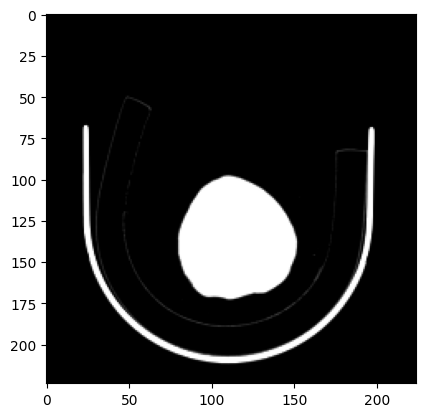

In [32]:
# preprocess_with_bounding_box("your_dicom_file.dcm", type="WINDOW", bounding_boxes)
f='D:\\sem5\\8 - EN2550 - Fundamentals of Image Processing & Machine Vision\\project\\CQ500CT2 CQ500CT2\\Unknown Study\\CT 0.625mm\\CT000023.dcm'

# {'x': 236.16402999999997, 'y': 151.01577, 'width': 50.876979999999996, 'height': 62.99052}
preprocess(f, type="WINDOW")

#plot the image figure
plt.imshow(preprocess(f, type="WINDOW"))
plt.show()

In [ ]:
import cv2
import numpy as np
import pydicom
import matplotlib.pyplot as plt

def draw_bounding_box(image, x, y, width, height, label):
    # Draw a bounding box on the image
    cv2.rectangle(image, (x, y), (x + width, y + height), (0, 255, 0), 2)
    
    # Add label text above the bounding box
    cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

def preprocess_with_bounding_box(file, type="WINDOW", bounding_boxes=None):
    dcm = pydicom.dcmread(file)
    if type == "WINDOW":
        window_center, window_width, intercept, slope = get_windowing(dcm)
        w = window_image(dcm, window_center, window_width)
        win_img = np.repeat(w[:, :, np.newaxis], 3, axis=2)
    elif type == "SIGMOID":
        window_center, window_width, intercept, slope = get_windowing(dcm)
        test_img = dcm.pixel_array
        w = sigmoid_window(dcm, window_center, window_width)
        win_img = np.repeat(w[:, :, np.newaxis], 3, axis=2)
    elif type == "BSB":
        win_img = bsb_window(dcm)
    elif type == "SIGMOID_BSB":
        win_img = sigmoid_bsb_window(dcm)
    elif type == "GRADIENT":
        win_img = rainbow_window(dcm)
    else:
        win_img = dcm.pixel_array

    # Resize the image
    resized = cv2.resize(win_img, (224, 224))
    
    if bounding_boxes:
        for box in bounding_boxes:
            x, y, width, height, label = box
            draw_bounding_box(resized, x, y, width, height, label)

    # Display the image (you can remove this if you don't want to display it)
    plt.imshow(resized, cmap='gray')
    plt.axis('off')
    plt.show()

    return resized

# Example usage:
# bounding_boxes = [(100, 50, 30, 40, "Lesion 1"), (150, 100, 40, 50, "Lesion 2")]
# preprocess_with_bounding_box("your_dicom_file.dcm", type="WINDOW", bounding_boxes)
f='/kaggle/input/qureai-headct/qct19/CQ500CT95 CQ500CT95/Unknown Study/CT PRE CONTRAST 5MM STD/CT000008.dcm'

# {'x': 236.16402999999997, 'y': 151.01577, 'width': 50.876979999999996, 'height': 62.99052}
preprocess(f, type="WINDOW")

#plot the image figure
plt.imshow(preprocess(f, type="WINDOW"))
plt.show()


C:\Users\Chamod Shyamal\AppData\Roaming\Python\Python311\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:177: UserWarning: The (0028,0101) 'Bits Stored' value doesn't match the sample bit depth of the JPEG2000 pixel data (16 vs 13 bit). It's recommended that you first change the 'Bits Stored' value to match the JPEG2000 bit depth in order to get the correct pixel data
  warnings.warn(


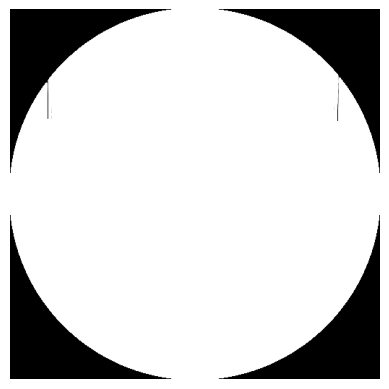

In [17]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pydicom
import os

# Function to preprocess the image array
def pre_process_im_arr(image_array):
    # Define window levels and widths for brain tissue
    window_level = 40  # Adjust this value based on your data
    window_width = 80  # Adjust this value based on your data

    # Apply windowing to the CT scan
    min_value = window_level - window_width / 2
    max_value = window_level + window_width / 2
    image_array[image_array < min_value] = min_value
    image_array[image_array > max_value] = max_value

    # Normalize the HU values to the range [0, 255]
    image_array = ((image_array - min_value) / (max_value - min_value) * 255).astype(np.uint8)

    # Apply morphology dilation to remove noise
    kernel = np.ones((3, 3), np.uint8)  # Adjust the kernel size as needed
    dilated_image = cv2.dilate(image_array, kernel, iterations=1)

    # Squeeze the extra dimension to convert it into a 2D array
    dilated_image = dilated_image.squeeze()

    return dilated_image

# Function to load a DICOM image
def load_dicom_image(dicom_path):
    ds = pydicom.dcmread(dicom_path)
    image_array = ds.pixel_array
    return image_array

# Specify the path to your DICOM image
dicom_path = 'D:\\sem5\\8 - EN2550 - Fundamentals of Image Processing & Machine Vision\\project\\CQ500CT2 CQ500CT2\\Unknown Study\\CT 0.625mm\\CT000009.dcm'
# Load the DICOM image
image_array = load_dicom_image(dicom_path)

# Preprocess the DICOM image
preprocessed_image = pre_process_im_arr(image_array)

# Display the preprocessed image using Matplotlib
plt.imshow(preprocessed_image, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()


In [18]:
class DataLoader(Sequence):
    def __init__(self, dataframe,
                 batch_size,
                 shuffle,
                 classes,
                 input_shape,
                 num_classes=6,
                 steps=None,
                 prep="BSB"):
        
        self.data_ids = dataframe.index.values
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.classes=classes
        self.current_epoch=0
        self.prep = prep
        self.steps=steps
        if self.steps is not None:
            self.steps = np.round(self.steps/3) * 3
            self.undersample()
        
    def undersample(self):
        part = np.int(self.steps/3 * self.batch_size)
        zero_ids = np.random.choice(self.dataframe.loc[self.dataframe["any"] == 0].index.values, size=10000, replace=False)
        hot_ids = np.random.choice(self.dataframe.loc[self.dataframe["any"] == 1].index.values, size=10000, replace=True)
        self.data_ids = list(set(zero_ids).union(hot_ids))
        np.random.shuffle(self.data_ids)
        
    # defines the number of steps per epoch
    def __len__(self):
        if self.steps is None:
            return np.int(np.ceil(len(self.data_ids) / np.float(self.batch_size)))
        else:
            return 3*np.int(self.steps/3) 
    
    # at the end of an epoch: 
    def on_epoch_end(self):
        # if steps is None and shuffle is true:
        if self.steps is None:
            self.data_ids = self.dataframe.index.values
            if self.shuffle:
                np.random.shuffle(self.data_ids)
        else:
            self.undersample()
        self.current_epoch += 1
    
    # should return a batch of images
    def __getitem__(self, item):
        # select the ids of the current batch
        current_ids = self.data_ids[item*self.batch_size:(item+1)*self.batch_size]
        X, y = self.__generate_batch(current_ids)
        return X, y
    
    # collect the preprocessed images and targets of one batch
    def __generate_batch(self, current_ids):
        X = np.empty((self.batch_size, *self.input_shape, 3))
        y = np.empty((self.batch_size, self.num_classes))
        for idx, ident in enumerate(current_ids):
            # Store sample
            #image = self.preprocessor.preprocess(ident) 
            image = preprocess(ident,self.prep)
            X[idx] = image
            # Store class
            y[idx] = self.__get_target(ident)
        return X, y
    
    # extract the targets of one image id:
    def __get_target(self, ident):
        targets = self.dataframe.loc[ident].values
        return targets

In [19]:
def DenseNet():
    densenet = DenseNet121(
    #weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
    weights='imagenet',
    include_top=False)
    return densenet
def ResNet():
    resnet = ResNet50V2(weights="imagenet",include_top=False)
    return resnet
def Inception():
    incept = InceptionV3(weights="imagenet",include_top=False)
    return incept

def get_backbone(name):
    if name == "RESNET":
        return ResNet
    elif name == "DENSE":
        return DenseNet
    elif name == "INCEPT":
        return Inception

def build_model(backbone):
    m = backbone()
    x = m.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(100, activation="relu")(x)
    x = Dropout(0.3)(x)
    pred = Dense(6,activation="sigmoid")(x)
    model = Model(inputs=m.input,outputs=pred)
    return model

In [20]:
# model = build_model(get_backbone("DENSE"))
# model.summary()

In [21]:
# model = build_model(get_backbone("RESNET"))
# model.summary()

In [22]:
# model = build_model(get_backbone("INCEPT"))
# model.summary()

In [23]:
train,test = train_test_split(pivot_df,test_size=0.2,random_state=42,shuffle=True)

split_seed = 1
kfold = StratifiedKFold(n_splits=5, random_state=split_seed,shuffle=True).split(np.arange(train.shape[0]), train["any"].values)

train_idx, dev_idx = next(kfold)

#Images Classes with index
train_data = train.iloc[train_idx]
dev_data = train.iloc[dev_idx]

#train_data, dev_data = train_test_split(traindf, test_size=0.1, stratify=traindf.values, random_state=split_seed)
print(train_data.shape)
print(dev_data.shape)

(481792, 6)
(120449, 6)


In [24]:
# def casting_focal_loss():
#     def inner_casting(y_true,y_pred):
#         y_true = tf.cast(y_true, tf.float32)
#         y_pred = tf.cast(y_pred, tf.float32)
#         return tfa.losses.SigmoidFocalCrossEntropy(y_true,y_pred)
    

METRICS = ['accuracy','Precision','Recall','AUC']
#LOSS = casting_focal_loss()
#LOSS = 'categorical_crossentropy'
LOSS='binary_crossentropy'
classes=['any','epidural','subdural','intraparenchymal','intraventricular','subarachanoid']

BATCH_SIZE =32
TRAIN_STEPS = 200#(train_data.shape[0] // BATCH_SIZE)
VAL_STEPS = 200#dev_data.shape[0] // BATCH_SIZE
TEST_STEPS=200
EPOCHS = 15

ALPHA = 0.5
GAMMA = 2

LR = 0.0001

PREP = "SIGMOID_BSB"
#for ARCH in ['RESNET','DENSE','INCEPT']:# Set Data Generator for training, testing and validataion.

# Note for testing, set shuffle = false (For proper Confusion matrix)

# Set Data Generator for training, testing and validataion.

# Note for testing, set shuffle = false (For proper Confusion matrix)

train_dataloader = DataLoader(train_data,
                              BATCH_SIZE,
                              shuffle=True,
                              classes=classes,
                              input_shape=(224,224),
                              steps=TRAIN_STEPS,
                              prep=PREP)

dev_dataloader = DataLoader(dev_data, 
                            BATCH_SIZE,
                            shuffle=True,
                            classes=classes,
                            input_shape=(224,224),
                            steps=VAL_STEPS,
                            prep=PREP)

test_dataloader = DataLoader(test,
                             BATCH_SIZE,
                             shuffle=False,
                             classes=classes,
                             input_shape=(224,224),
                             steps=TEST_STEPS,
                             prep=PREP)


    
cpath = "./" + "RESNET" + "_" + PREP + "_" + str(TRAIN_STEPS) + "_" + str(EPOCHS) 

checkpoint = ModelCheckpoint(filepath=cpath + ".model",mode="min",verbose=1,save_best_only=True,save_weights_only=False,period=1)

model = build_model(get_backbone("RESNET"))

#compile the model
model.compile(optimizer=Adam(learning_rate=LR),loss=LOSS,metrics=[METRICS,tfa.metrics.F1Score(num_classes=6, average="micro")])

#Train the model
history = model.fit_generator(generator=train_dataloader,validation_data=dev_dataloader,epochs=EPOCHS,workers=8,callbacks=[checkpoint])

with open(cpath + ".history", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


94674944/94668760 [==============================] - 1s 0us/step


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
201/201 [==============================] - 174s 806ms/step - loss: 0.4449 - accuracy: 0.6916 - precision: 0.4740 - recall: 0.3988 - auc: 0.7573 - f1_score: 0.3790 - val_loss: 0.2796 - val_accuracy: 0.8433 - val_precision: 0.7195 - val_recall: 0.5433 - val_auc: 0.9021 - val_f1_score: 0.4273

Epoch 00001: val_loss improved from inf to 0.27957, saving model to ./RESNET_SIGMOID_BSB_200_15.model
Epoch 2/15
201/201 [==============================] - 164s 805ms/step - loss: 0.3056 - accuracy: 0.7539 - precision: 0.7281 - recall: 0.5302 - auc: 0.8876 - f1_score: 0.4307 - val_loss: 0.2575 - val_accuracy: 0.9081 - val_precision: 0.8086 - val_recall: 0.5203 - val_auc: 0.9127 - val_f1_score: 0.4280

Epoch 00002: val_loss improved from 0.27957 to 0.25748, saving model to ./RESNET_SIGMOID_BSB_200_15.model
Epoch 3/15
201/201 [==============================] - 164s 807ms/step - loss: 0.2768 - accuracy: 0.7649 - precision: 0.7592 - recall: 0.6003 - auc: 0.9081 - f1_score: 0.4421 - val_loss: 

In [25]:
    
print("Evaluate")
test_prob = model.evaluate(test_dataloader,steps=200)
res = dict(zip(model.metrics_names, test_prob))
print(res)

Evaluate


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


200/200 [==============================] - 179s 896ms/step - loss: 0.2142 - accuracy: 0.9741 - precision: 0.9010 - recall: 0.6142 - auc: 0.9470 - f1_score: 0.4360
{'loss': 0.21421384811401367, 'accuracy': 0.9740625023841858, 'precision': 0.900964617729187, 'recall': 0.6142042875289917, 'auc': 0.9470321536064148, 'f1_score': 0.4360039234161377}


In [26]:
from sklearn.metrics import multilabel_confusion_matrix

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
print("Model Prediction ")
y_pred =model.predict_generator(test_dataloader)

print (y_pred)


Model Prediction 


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[[8.34581908e-04 6.23966935e-06 1.08274304e-04 2.01857874e-05
  4.15559713e-04 4.61997661e-05]
 [4.05038111e-02 3.32582073e-04 1.25481316e-03 1.61911093e-03
  1.60550084e-02 3.29537946e-03]
 [7.00345077e-03 7.94343432e-05 5.79845742e-04 7.93286017e-05
  6.74313307e-03 9.31251328e-04]
 ...
 [1.17104635e-01 6.48611831e-03 4.49478328e-02 4.78764763e-03
  4.23563235e-02 3.50748934e-02]
 [9.97898340e-01 1.40298461e-03 8.60299051e-01 9.23917353e-01
  8.79374817e-02 1.02202203e-02]
 [9.75172877e-01 4.44772933e-03 3.82664204e-02 6.46915101e-03
  9.02339697e-01 4.02775019e-01]]


In [28]:
!pip install scikit-plot

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [29]:
import itertools
from sklearn.metrics import multilabel_confusion_matrix
import sklearn.metrics as skm
nr_batches = 32
threshold = 0.5
img_0, img_1 = itertools.tee(test_dataloader, 2)
y_true = np.vstack(next(img_0)[1] for _ in range(nr_batches)).astype('int')
y_pred = (model.predict_generator(img_1, steps=nr_batches) > threshold).astype('int')
print(skm.multilabel_confusion_matrix(y_true, y_pred))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  import sys
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[[[ 564   26]
  [  91  343]]

 [[1009    0]
  [  15    0]]

 [[ 857   18]
  [  43  106]]

 [[ 898   12]
  [  42   72]]

 [[ 865   19]
  [  63   77]]

 [[ 822    7]
  [ 127   68]]]


In [30]:
from sklearn.metrics import classification_report,confusion_matrix
print( skm.classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.79      0.85       434
           1       0.00      0.00      0.00        15
           2       0.85      0.71      0.78       149
           3       0.86      0.63      0.73       114
           4       0.80      0.55      0.65       140
           5       0.91      0.35      0.50       195

   micro avg       0.89      0.64      0.74      1047
   macro avg       0.73      0.51      0.59      1047
weighted avg       0.88      0.64      0.72      1047
 samples avg       0.32      0.27      0.29      1047



/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7

In [31]:
# # predicting on test data.
    
# print("Predict")
# Y_pred =model.predict_generator(test_dataloader.classes)
# y_pred = np.argmax(Y_pred, axis=1)# get the class with highest probability for each sample
# y_pred= dict(zip(model.metrics_names, y_pred))
# print(y_pred)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
# #Get the accuracy score

# test_score = model.evaluate_generator(test_dataloader,32)
# print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 

# print("[INFO] Loss: ",test_score[0])

In [33]:

# from sklearn.metrics import classification_report,confusion_matrix
# #Confution Matrix 
# # print('Confusion Matrix')
# # print(confusion_matrix(test_dataloader,pred_test))


In [34]:
# print('Classification Report')
# print(classification_report(test_dataloader, y_pred))


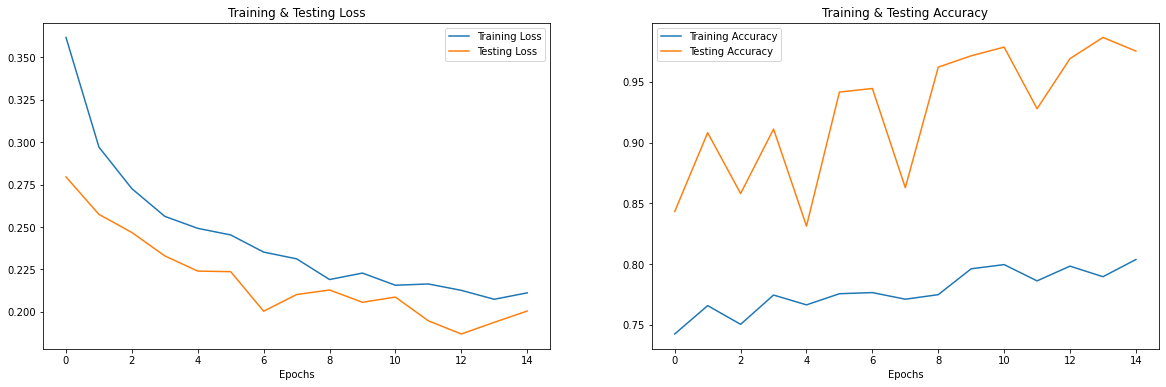

In [35]:
epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [36]:
from sklearn.metrics import roc_auc_score
macro_roc_auc_ovo = roc_auc_score(y_true, y_pred, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_true, y_pred, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_true, y_pred, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_true, y_pred, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.743689 (macro),
0.804513 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.743689 (macro),
0.804513 (weighted by prevalence)


In [37]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  if sys.path[0] == '':


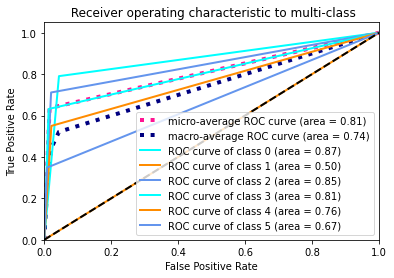

In [38]:
#First aggregate all false positive rates
from scipy import interp
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
lw = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(6)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(6):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 6

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(6), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(' Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()